# Environment

In [1]:
!nvidia-smi

Tue Feb 25 04:46:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.16                 Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080      WDDM  |   00000000:0A:00.0  On |                  N/A |
| 34%   43C    P5             21W /  200W |    1880MiB /   8192MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import os
from pprint import pprint
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode
from torchinfo import summary

import medmnist
from medmnist import INFO

import src.medmnist_dataset as md
from src.architectures import architecture, VisionTransformer
from src.train import train_loop, EarlyStopping
from src.utils import compute_class_weights, custom_theme, plot_and_save_metrics

In [2]:
# Set the global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
# Get CWD
CWD = os.getcwd()

In [4]:
print(medmnist.__version__)

3.0.2


# Data

## Data Info

In [6]:
avaliable_datasets = ["pathmnist", "dermamnist", \
                    "octmnist", "pneumoniamnist", "breastmnist", \
                    "bloodmnist", "tissuemnist", "organamnist", \
                    "organcmnist", "organsmnist"] # "retinamnist", "chestmnist"]

In [7]:
sample_counts = []

for dataset_name in avaliable_datasets:
    
    info = INFO[dataset_name]
    print(f"-"*100)
    print(f"Dataset: {dataset_name}")
    print(f"Python: {info['python_class']}")
    print(f"Task: {info['task']}")
    print(f"Number of classes: {len(info['label'])}")
    print(f"Channels: {info['n_channels']}")
    print("Classes:")
    pprint(info['label'])

    sample_counts.append(info["n_samples"]["train"])

----------------------------------------------------------------------------------------------------
Dataset: pathmnist
Python: PathMNIST
Task: multi-class
Number of classes: 9
Channels: 3
Classes:
{'0': 'adipose',
 '1': 'background',
 '2': 'debris',
 '3': 'lymphocytes',
 '4': 'mucus',
 '5': 'smooth muscle',
 '6': 'normal colon mucosa',
 '7': 'cancer-associated stroma',
 '8': 'colorectal adenocarcinoma epithelium'}
----------------------------------------------------------------------------------------------------
Dataset: dermamnist
Python: DermaMNIST
Task: multi-class
Number of classes: 7
Channels: 3
Classes:
{'0': 'actinic keratoses and intraepithelial carcinoma',
 '1': 'basal cell carcinoma',
 '2': 'benign keratosis-like lesions',
 '3': 'dermatofibroma',
 '4': 'melanoma',
 '5': 'melanocytic nevi',
 '6': 'vascular lesions'}
----------------------------------------------------------------------------------------------------
Dataset: octmnist
Python: OCTMNIST
Task: multi-class
Number 

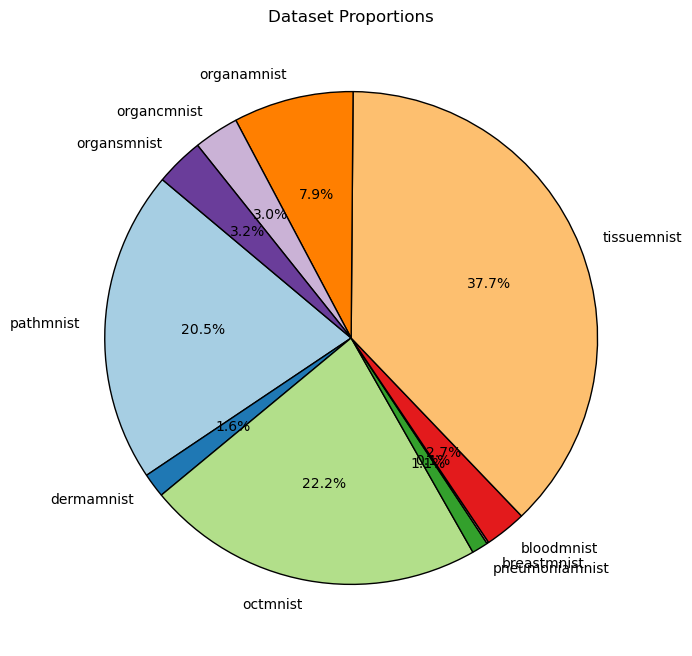

In [8]:
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sample_counts,
    labels              = avaliable_datasets,
    autopct             = "%1.1f%%",
    startangle          = 140,
    colors              = plt.cm.Paired.colors,
    wedgeprops          = {"edgecolor": "black"}
)

# Add a title
plt.title("Dataset Proportions")

# Show the plot
plt.show()

## Data Download

In [9]:
image_size = 28 # 28, 64, 128 or 256
datasets_path = os.path.join(CWD, "datasets", str(image_size))
os.makedirs(datasets_path, exist_ok=True)

md.download(avaliable_datasets, datasets_path, image_size)

File d:\AI\med-mnist\datasets\28\pathmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\dermamnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\octmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\pneumoniamnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\breastmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\bloodmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\tissuemnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\organamnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\organcmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\organsmnist_28.npz already exists. Skipping download.


## Dataset Unification

In [10]:
organ_datasets = ["organamnist", "organcmnist", "organsmnist"] # These are the same - have the same classes

md.unify_data(
    organ_datasets,
    are_unique_classes      = False,
    image_size              = image_size,
    datasets_path           = datasets_path,
    save_path               = datasets_path,
    filename                = f"organs_{image_size}"
);

File d:\AI\med-mnist\datasets\28\organs_28.npz already exists.


In [11]:
new_avaliable_datasets = ["organs", "pathmnist", "dermamnist", "octmnist", "pneumoniamnist", \
                            "breastmnist", "bloodmnist", "tissuemnist"]

md.unify_data(
    new_avaliable_datasets,
    are_unique_classes      = True,
    image_size              = image_size,
    datasets_path           = datasets_path,
    save_path               = datasets_path,
    filename                = f"unified_{image_size}"
);

File d:\AI\med-mnist\datasets\28\unified_28.npz already exists.


## Dataset

In [12]:
transform = v2.Compose(
    [
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]
)

# Training augmentations
augmentation = v2.Compose(
    [
        transform,
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.Pad(round(image_size/10), padding_mode="reflect"),
        v2.RandomRotation(degrees=20, interpolation=InterpolationMode.BILINEAR),
        v2.CenterCrop(size=(image_size, image_size))
    ]
)

In [13]:
unified_dataset_path = os.path.join(datasets_path, f"unified_{image_size}.npz")

train_dataset = md.NPZDataset(
    unified_dataset_path,
    split           = "train",
    transform       = augmentation,
    mmap_mode       = None
)

validation_dataset = md.NPZDataset(
    unified_dataset_path,
    split           = "val",
    transform       = transform,
    mmap_mode       = "r"
)

test_dataset = md.NPZDataset(
    unified_dataset_path,
    split           = "test",
    transform       = transform,
    mmap_mode       = "r"
)

## Data Loader

In [14]:
batch_size = 512
num_workers = 4

In [ ]:
if num_workers > 0:
    prefetch_factor = 2
else:
    prefetch_factor = None
    

train_loader = DataLoader(
    train_dataset,
    batch_size          = batch_size, 
    shuffle             = True,
    num_workers         = num_workers,
    prefetch_factor     = prefetch_factor,
    persistent_workers  = True,
    # pin_memory          = True
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size          = batch_size, 
    shuffle             = False,
    num_workers         = num_workers,
    prefetch_factor     = prefetch_factor,
    persistent_workers  = True,
    # pin_memory          = True
)

test_loader = DataLoader(
    validation_dataset,
    batch_size          = batch_size, 
    shuffle             = False,
    num_workers         = num_workers,
    prefetch_factor     = prefetch_factor,
    persistent_workers  = True,
    # pin_memory          = True
)

### Test Data Loader

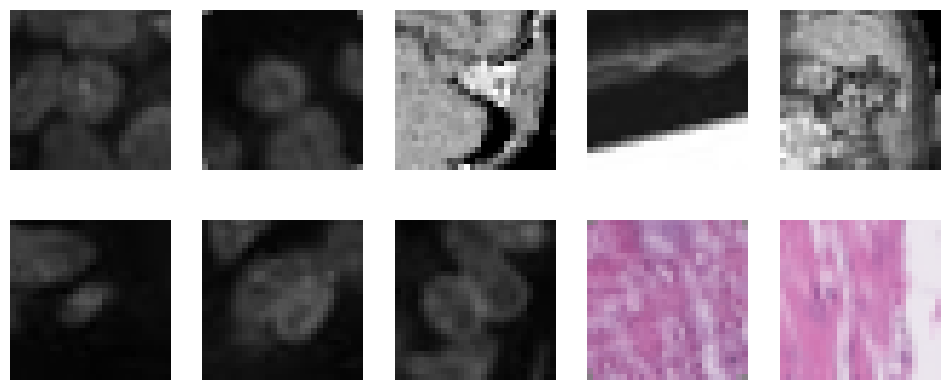

In [16]:
# Get one batch from train_loader
batch = next(iter(train_loader))
images, labels = batch  # Unpack batch

# # Denormalize for visualization
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)  # Shape (C, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)

# Convert images back to [0, 1] range for visualization
images = images * std + mean  
images = torch.clamp(images, 0, 1)  # Ensure values stay in range

# Plot some images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))  # Grid 2x5
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) → (H, W, C)
    ax.imshow(img)
    ax.axis("off")

plt.show()

# Training

## Parameters

Counts per class: Counter({43: 53075, 30: 46026, 49: 39203, 27: 33484, 50: 24608, 46: 15406, 19: 12885, 6: 12614, 16: 12182, 47: 11789, 14: 10401, 13: 10360, 28: 10213, 12: 9509, 18: 9401, 11: 9366, 15: 8006, 17: 7886, 44: 7814, 29: 7754, 48: 7705, 10: 6689, 9: 6208, 4: 6183, 5: 6106, 45: 5866, 8: 5754, 7: 5662, 25: 4693, 0: 4252, 32: 3494, 3: 2795, 1: 2639, 2: 2566, 41: 2330, 36: 2181, 38: 2026, 42: 1643, 31: 1214, 37: 1085, 40: 993, 35: 852, 39: 849, 24: 779, 22: 769, 34: 399, 21: 359, 20: 228, 33: 147, 26: 99, 23: 80})


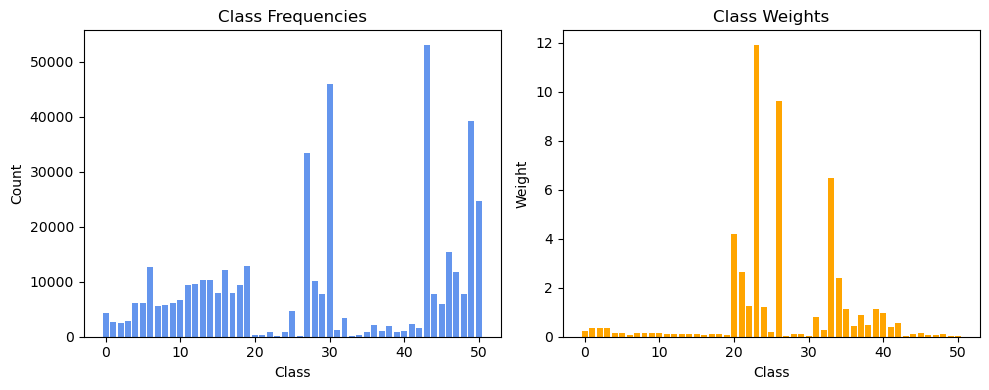

In [17]:
temp_dataset = md.NPZDataset(
    unified_dataset_path,
    split           = "train",
    mmap_mode       = "r"
)

class_weights_tensor = compute_class_weights(temp_dataset)
del temp_dataset

In [18]:
min_epochs      = 1
max_epochs      = 3
arch            = "vit"

optimizer_name  = "AdamW"
lr              = 1e-1
momentum        = 1
weight_decay    = 1e-4
betas           = (0.9, 0.999)
amsgrad         = True

stat_to_track   = "val_loss" # "train_loss" "train_acc" "val_loss" "val_acc"
mode            = "min" # "min" "max"
delta           = 5e-2

In [19]:
num_classes     = 51
patch_size      = 4
depth           = 1 #8
num_heads       = 1 #8
mlp_ratio       = 1 #4
dropout         = 0.5

projection_dim = patch_size * patch_size * 3

## Model

In [20]:
import lightning as L
from torch.nn import functional as F
import torchmetrics

class LightningModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters({
            "min_epochs":       min_epochs,
            "max_epochs":       max_epochs,
            "arch":             arch,
            "optimizer_name":   optimizer_name,
            "lr":               lr,
            "momentum":         momentum,
            "weight_decay":     weight_decay,
            "betas":            betas,
            "amsgrad":          amsgrad,
            "num_classes":      num_classes,
            "patch_size":       patch_size,
            "projection_dim":   projection_dim,
            "depth":            depth,
            "num_heads":        num_heads,
            "mlp_ratio":        mlp_ratio,
            "dropout":          dropout
        })

        # Create the model
        self.model = VisionTransformer(
            image_size      = image_size,
            patch_size      = patch_size,
            in_channels     = 3,
            num_classes     = num_classes,
            projection_dim  = projection_dim,
            depth           = depth,
            num_heads       = num_heads,
            mlp_ratio       = mlp_ratio,
            dropout         = dropout
        )

        # Choose optimizer
        if optimizer_name == "SGD":
            self.optimizer = optim.SGD(
                self.model.parameters(),
                lr              = lr,
                momentum        = momentum,
                weight_decay    = weight_decay
            )
        elif optimizer_name == "Adam":
            self.optimizer = optim.Adam(
                self.model.parameters(),
                lr              = lr,
                weight_decay    = weight_decay
            )
        elif optimizer_name == "AdamW":
            self.optimizer = optim.AdamW(
                self.model.parameters(),
                lr              = lr,
                weight_decay    = weight_decay,
                betas           = betas,
                amsgrad         = amsgrad
            )
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")

        # Learning rate scheduler
        self.lr_scheduler = CosineAnnealingLR(self.optimizer, T_max=max_epochs)

        # Metrics
        # For multi-class classification with 51 classes:
        self.train_acc  = torchmetrics.Accuracy(task="multiclass", num_classes=51)
        self.val_acc    = torchmetrics.Accuracy(task="multiclass", num_classes=51)
        self.test_acc   = torchmetrics.Accuracy(task="multiclass", num_classes=51)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        # Return in Lightning's format
        return [self.optimizer], [self.lr_scheduler]

    def training_step(self, batch, batch_idx):
        inputs, labels  = batch
        logits          = self(inputs)

        # Cross-entropy expects (logits, target)
        loss = F.cross_entropy(
            logits,
            labels,
            weight=class_weights_tensor.to(device)
        )

        # Update & log training accuracy
        acc = self.train_acc(logits, labels)
        self.log("train_loss",  loss,   on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc",   acc,    on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels  = batch
        logits          = self(inputs)
        val_loss        = F.cross_entropy(  logits, labels)
        val_acc         = self.val_acc(     logits, labels)
        
        self.log("val_loss",    val_loss,   prog_bar=True)
        self.log("val_acc",     val_acc,    prog_bar=True)

        return val_loss

    def test_step(self, batch, batch_idx):
        inputs, labels  = batch
        logits          = self(inputs)
        test_loss       = F.cross_entropy(  logits, labels)
        test_acc        = self.test_acc(    logits, labels)

        self.log("test_loss",   test_loss,  prog_bar=True)
        self.log("test_acc",    test_acc,   prog_bar=True)

        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        inputs, labels = batch
        return self(inputs)

    def get_model(self):
        return self.model

In [21]:
model = LightningModel()

In [22]:
summary(
    model.get_model(),
    input_size  = (batch_size, 3, image_size, image_size),
    mode        = "train"
)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [512, 51]                 2,448
├─PatchEmbedding: 1-1                         [512, 49, 48]             --
│    └─Patchify: 2-1                          [512, 49, 48]             --
│    └─Linear: 2-2                            [512, 49, 48]             2,352
├─Dropout: 1-2                                [512, 50, 48]             --
├─Sequential: 1-3                             [512, 50, 48]             --
│    └─TransformerBlock: 2-3                  [512, 50, 48]             --
│    │    └─LayerNorm: 3-1                    [512, 50, 48]             96
│    │    └─MultiHeadSelfAttention: 3-2       [512, 50, 48]             9,408
│    │    └─Dropout: 3-3                      [512, 50, 48]             --
│    │    └─LayerNorm: 3-4                    [512, 50, 48]             96
│    │    └─Sequential: 3-5                   [512, 50, 48]             4,704
│    │  

In [23]:
models_dir_path = os.path.join(CWD, "models")
os.makedirs(models_dir_path, exist_ok=True)

model_filename = f"{arch}_sz{image_size}_d{depth}_h{num_heads}_mlr{mlp_ratio}"

In [24]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, RichProgressBar#, TQDMProgressBar


early_stopping = EarlyStopping(
    monitor                 = stat_to_track,
    mode                    = mode,
    patience                = min_epochs,
    min_delta               = delta
)

checkpoint_callback = ModelCheckpoint(
    dirpath                 = models_dir_path,
    filename                = model_filename,
    monitor                 = stat_to_track,
    mode                    = mode,
    save_top_k              = 1,
    save_last               = True,
    enable_version_counter  = True
)

progress_bar = RichProgressBar(
    leave                   = True,
    theme                   = custom_theme
)

# progress_bar = TQDMProgressBar(
#     leave                   = True,
#     refresh_rate            = 1
# )

trainer = Trainer(
    devices                 = -1,
    min_epochs              = min_epochs,
    max_epochs              = max_epochs,
    callbacks               = [early_stopping, checkpoint_callback, progress_bar],
    enable_model_summary    = True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\J\miniconda3\envs\med-mnist\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [25]:
trainer.fit(model, train_loader, validation_loader)

c:\Users\J\miniconda3\envs\med-mnist\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory D:\AI\med-mnist\models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ VisionTransformer  │ 21.7 K │ train │
│ 1 │ train_acc │ MulticlassAccuracy │      0 │ train │
│ 2 │ val_acc   │ MulticlassAccuracy │      0 │ train │
│ 3 │ test_acc  │ MulticlassAccuracy │      0 │ train │
└───┴───────────┴────────────────────┴────────┴───────┘

Trainable params: 21.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 21.7 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 22                                                                                          
Modules in eval mode: 0

Output()

Output()

Output()

`Trainer.fit` stopped: `max_epochs=3` reached.


# Testing

In [26]:
trainer.test(
    dataloaders = test_loader,
    ckpt_path   = "best"
)

Restoring states from the checkpoint path at D:\AI\med-mnist\models\vit_sz28_d1_h1_mlr1-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at D:\AI\med-mnist\models\vit_sz28_d1_h1_mlr1-v4.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.036581654101610184    │
│         test_loss         │    3.5342164039611816     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.5342164039611816, 'test_acc': 0.036581654101610184}]

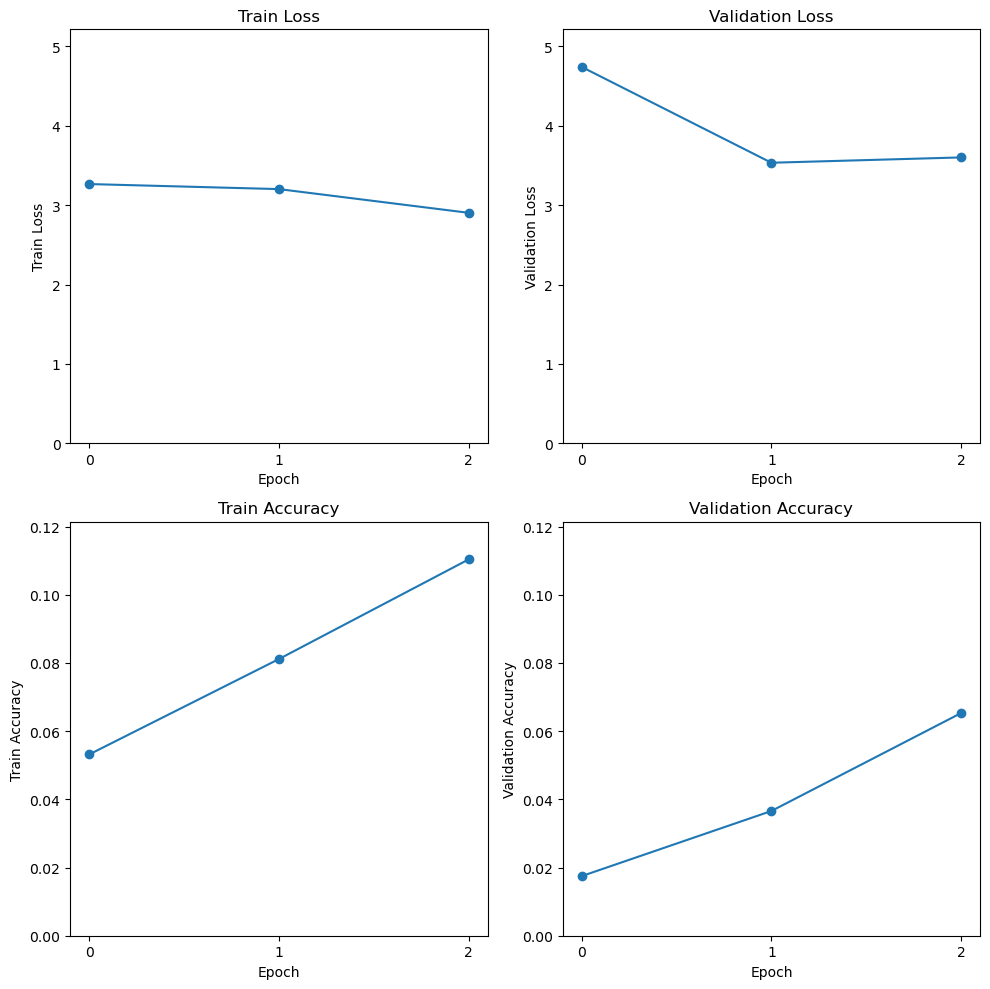

Plot saved to d:\AI\med-mnist\lightning_logs\version_6\metrics_plot.png


In [5]:
# current_version = trainer.logger.version
current_version = 6
# print("Current run version:", current_version)

logs_path = os.path.join(CWD, "lightning_logs", f"version_{current_version}")

plot_and_save_metrics(logs_path)